# Preprocessing Jupiter Notebook: 
gets the data scraped by the scrape.py scripts, creates dataframes from the lists and preprocesses for the machine learning model
1. part 1: create the dataframe from the scraped data

In [3]:
import pandas as pd
from scrape import customer_service_reviews, comments, dates, satisfaction_reviews, speed_reviews, reliability_reviews, customer_service_reviews

AttributeError: partially initialized module 'pandas' has no attribute 'core' (most likely due to a circular import)

In [ ]:
#combine all list values to a df:
#create the dictionary that will make up the dataframe
df_dict={"Dates": dates, "Comments": comments, "Customer Service": customer_service_reviews, "Satisfaction Reviews": satisfaction_reviews, "Speed Reviews": speed_reviews, "Reliability Reviews": reliability_reviews}

#as certain columns are shorter than others use a trick to create a df with unequal arrays:https://stackoverflow.com/questions/19736080/creating-dataframe-from-a-dictionary-where-entries-have-different-lengths
df = pd.DataFrame.from_dict(df_dict, orient='index')
df=df.transpose()

In [ ]:
#convert the dates columns from string to datetime object:
df["Dates"]= pd.to_datetime(df["Dates"])

In [ ]:
#save date to csv:
df.to_csv('raw_data.csv')

2. data cleaning: Dealing with the null values 

In [14]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
#first read csv dropped unnamed columns and inspect the first few rows
raw_df= pd.read_csv("raw_data.csv")
raw_df.drop("Unnamed: 0", axis=1, inplace=True)
print(raw_df.shape) 

(1960, 6)


In [3]:
raw_df.head()

,Dates,Comments,Customer Service,Satisfaction Reviews,Speed Reviews,Reliability Reviews
0,2022-11-15,Moved back to the UK end of August and got Vir...,1.0,1.0,1.0,1.0
1,2022-11-14,"A truly attrocious service, both in terms of b...",1.0,1.0,1.0,1.0
2,2022-11-13,They make it as hard as they can for you to ca...,1.0,1.0,2.0,2.0
3,2022-11-11,Pay for the 350Mbps package but only ever mana...,1.0,1.0,3.0,2.0
4,2022-11-11,The worst customer service:\r-The bots ask irr...,1.0,1.0,3.0,2.0


check if any of the comment rows are empty. If they are we are forced to drop this row as the main project revolves around nlp

In [4]:
raw_df['Comments'].isnull().values.any()

True

drop any reviews that have no text as of now use to us.

In [5]:
raw_df.dropna(subset=['Comments'], inplace=True)

In [6]:
raw_df.shape

(1959, 6)

Now that rows with missing comments have been dropped lets look at the rest of the missing data. We will deal with the missing values bu using scikit learn's simple imputer, that will impute the missing data in each column for us accoprding the to the most common value. First take a look at what columns have missing values:

In [20]:
raw_df['Satisfaction Reviews'].isnull().values.sum()

70

In [21]:
raw_df['Speed Reviews'].isnull().values.sum()

179

In [19]:
raw_df['Reliability Reviews'].isnull().values.sum()

231

In [22]:
raw_df['Customer Service'].isnull().values.sum()

104

We can see that all the numerical columns have missing values, and we will have to impute the missing values with a simple imputer as there might be a correlation between them first.We have:

* 70 missing satisfaction reviews
* 179 missing speed reviews
* 231 missing reliability reviews
* 104 missing customer service reviews
 
So let's look at a correlation matrix to see whether there is a correlation:
 


C:\Users\amilc\AppData\Local\Temp\ipykernel_14208\1897695697.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr =raw_df.corr()


<AxesSubplot: >

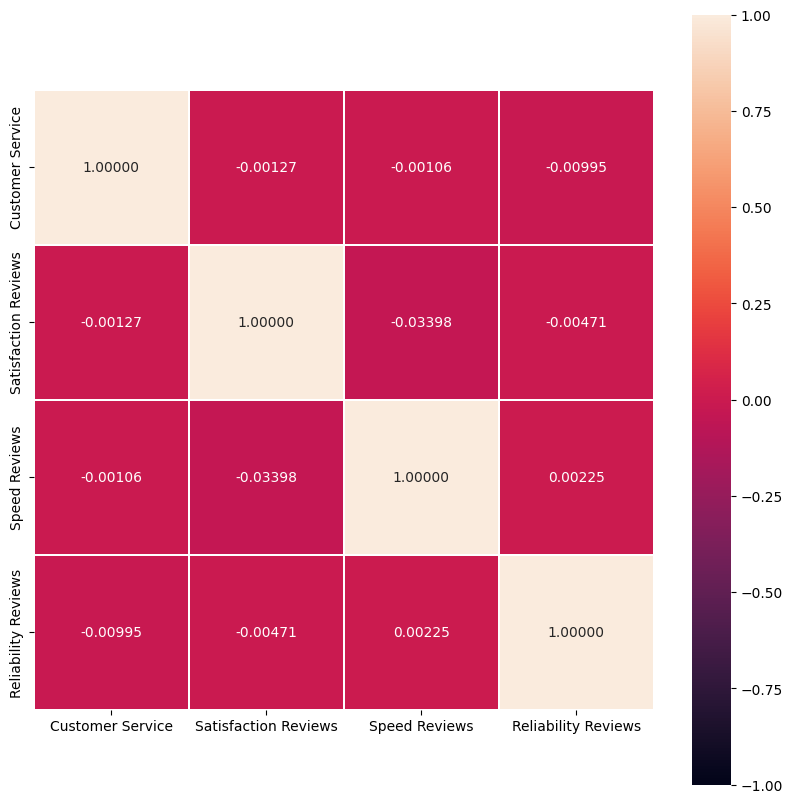

In [17]:
# Generate a mask for the upper triangle
corr =raw_df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

#Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(10,10))

# Draw the heatmap with 'sns.heatmap()'
   
sns.heatmap(corr, vmin=-1,vmax=1, square=True, fmt='.5f', linewidths='0.05', annot=True)


From the heatmap we can see that the strongest correlation (with a  value of -0.003398) is between Speed reviews and and Satisfaction Reviews, and coming after we have relaiblity and customer service reviews.

To account for these correlations we shall use a KNN Imputer. We shall use all the numerical features, and set  the n_neighbours=2 (this parameter can be fine tuned if required).

Here is how the algorithm works: Let's say that we have a row in which the speed reviews are missing. Scikit learn will find the two most similar rows (as neighbours =2) , measured to how close the the other features  (customer service, reliability, satisfaction) are to our original row and it averages the speed values of those rows and imputes the value in our orignal row.

Each row can have mulitple missing values, the algorithm takes that into account as well, there is logic for that.


In [26]:
from sklearn.impute import KNNImputer

imputer =KNNImputer() # neighbours are set to 5 by default
#fit on dataset
X=raw_df.drop(["Comments", "Dates"], axis=1)
imputer.fit(X)

KNNImputer()

In [27]:
...
# transform the dataset
Xtrans = imputer.transform(X)

In [30]:
raw_df.head()

,Dates,Comments,Customer Service,Satisfaction Reviews,Speed Reviews,Reliability Reviews
0,2022-11-15,Moved back to the UK end of August and got Vir...,1.0,1.0,1.0,1.0
1,2022-11-14,"A truly attrocious service, both in terms of b...",1.0,1.0,1.0,1.0
2,2022-11-13,They make it as hard as they can for you to ca...,1.0,1.0,2.0,2.0
3,2022-11-11,Pay for the 350Mbps package but only ever mana...,1.0,1.0,3.0,2.0
4,2022-11-11,The worst customer service:\r-The bots ask irr...,1.0,1.0,3.0,2.0


In [34]:
#merging this dataframe with the other two daatframes
imputed_df = pd. DataFrame(Xtrans, columns=['Customer Service', 'Satisfaction Reviews', "Speed Reviews", "Reliability Reviews"]) 
dates_comments_df= raw_df[["Dates", "Comments"]]

In [36]:
#this is the merged dataframe
knn_imputed= pd.concat([dates_comments_df, imputed_df], axis=1) 

In [37]:
knn_imputed.head()

,Dates,Comments,Customer Service,Satisfaction Reviews,Speed Reviews,Reliability Reviews
0,2022-11-15,Moved back to the UK end of August and got Vir...,1.0,1.0,1.0,1.0
1,2022-11-14,"A truly attrocious service, both in terms of b...",1.0,1.0,1.0,1.0
2,2022-11-13,They make it as hard as they can for you to ca...,1.0,1.0,2.0,2.0
3,2022-11-11,Pay for the 350Mbps package but only ever mana...,1.0,1.0,3.0,2.0
4,2022-11-11,The worst customer service:\r-The bots ask irr...,1.0,1.0,3.0,2.0


check if this new dataframe has any missing values after applying the algorithm. We can see that it has 6.

In [42]:
knn_imputed.isnull().values.sum()

6

Now to figure out where these values are.